## PROYECTO PONDS

In [254]:
#importamos librerías
import imageio as imageio
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"C:\\Users\\Margarita Zerpa\\Documents\\INTRODUCCIÓN AL PROCESAMIENTO DE IMAGENES\\TRABAJOS PRACTICOS\\IPDI-2023\\PONDS")

In [255]:
import operaciones_img as ope

In [256]:
im1 = imageio.imread('ponds.bmp')

C:\Users\Margarita Zerpa\AppData\Local\Temp\ipykernel_6828\627909051.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread('ponds.bmp')


In [257]:
#FUNCIÓN PARA GRAFICAR IMAGEN E HISTOGRAMA
def mostrar_imagen_y_histograma(imagen, histograma, bins):
    # Crear una figura con dos subtramas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Subtrama 1: Mostrar la imagen
    ax1.imshow(imagen)
    ax1.set_title("Imagen Normalizada")

    # Subtrama 2: Mostrar el histograma
    ax2.bar(bins[:-1], histograma, width=0.01, align='center', alpha=0.5, color='black')
    ax2.set_title("Histograma")
    ax2.set_xlabel("Valores de pixeles")
    ax2.set_ylabel("Frecuencia")

    # Especificar los valores que deseas mostrar en el eje x
    ax2.set_xticks([0, 0.5, 1])

    # Desactivar la cuadrícula en la subtrama del histograma
    ax2.grid(False)

    # Ajustar el espacio entre las subtramas
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

## VISUALIZAMOS IMAGEN ORIGINAL Y SU HISTOGRAMA

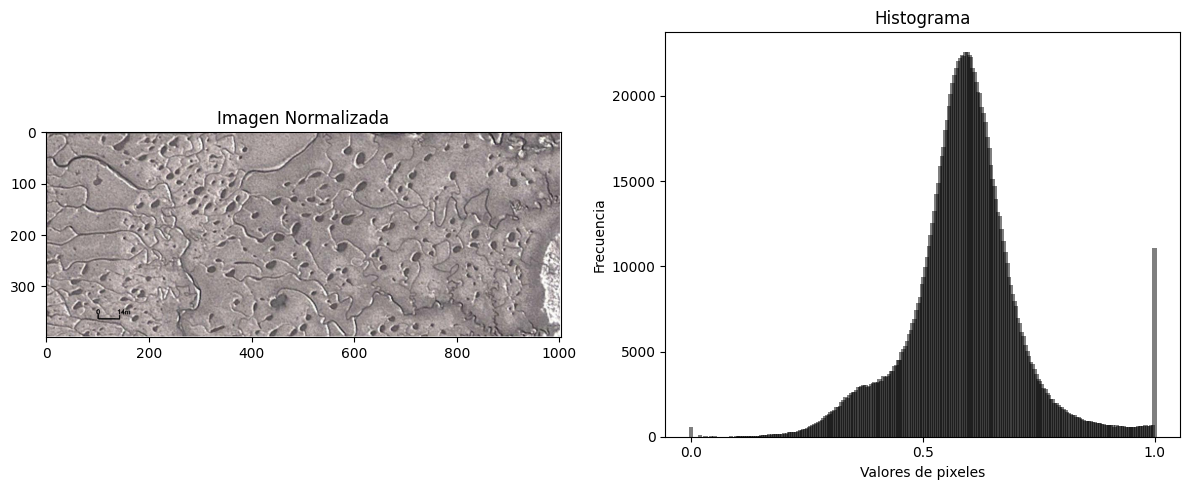

In [258]:
#normalizamos
imagenNormalizada = ope.normalize_rgb(im1)

# Genera un histograma
histogram, bins = np.histogram(imagenNormalizada.flatten(), bins=1000, range=(0, 1))
mostrar_imagen_y_histograma(imagenNormalizada, histogram, bins)

## APLICACION LINEAL A TRAZOS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


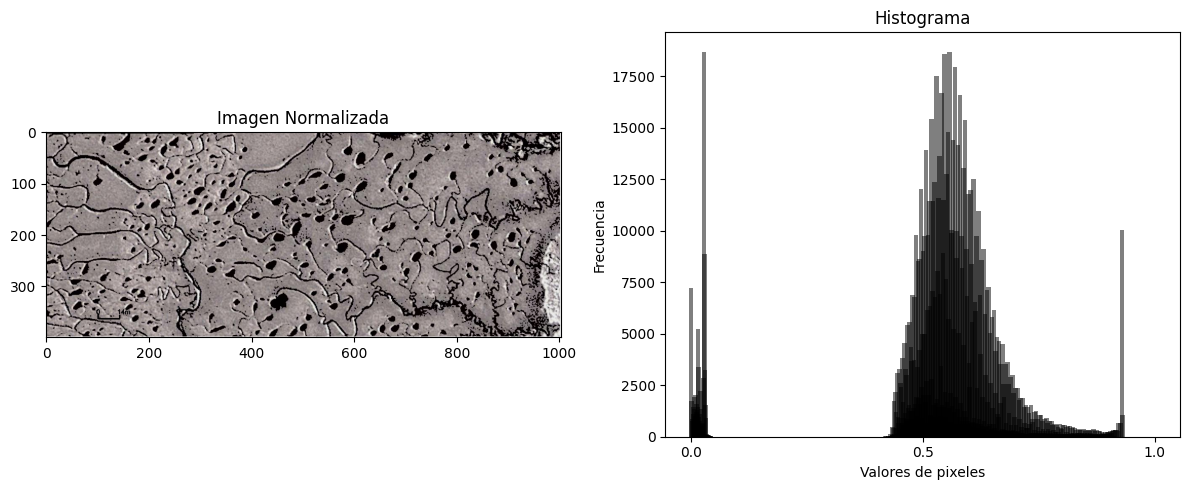

In [259]:
yiq = ope.RGB_to_YIQ(imagenNormalizada)
imagen_binarizada= ope.lineal_a_tarzos(yiq,0.45,1)
imagenProcesada=ope.YIQ_to_RGB(imagen_binarizada)

# mostrar imagen procesada y visualizamos su histograma
histogram1, bins1 = np.histogram(imagenProcesada.flatten(), bins=1000, range=(0, 1))
mostrar_imagen_y_histograma(imagenProcesada, histogram1, bins1)

## APLICACIÓN  MEANSHIFT

In [260]:
from sklearn.cluster import MeanShift, estimate_bandwidth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


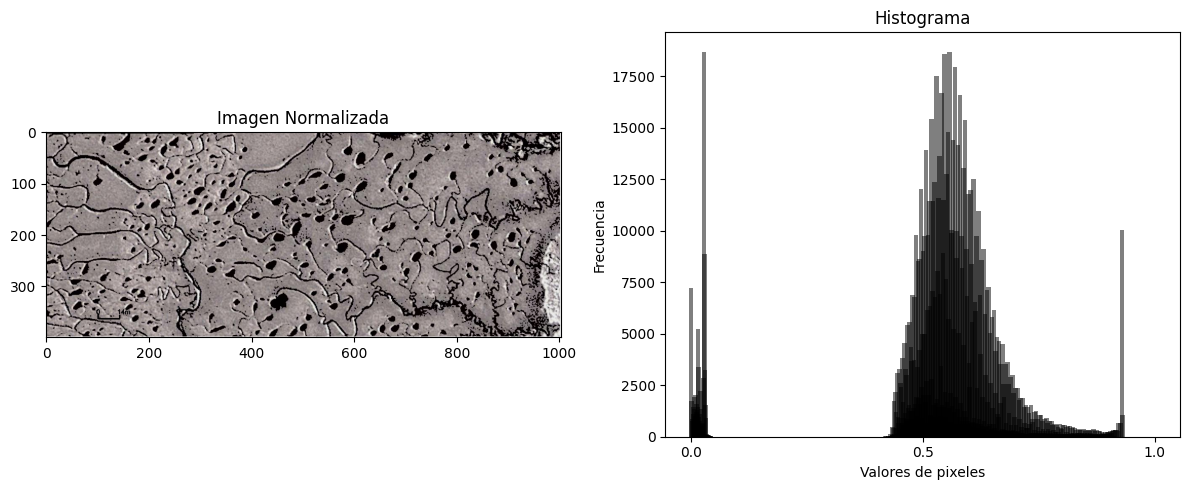

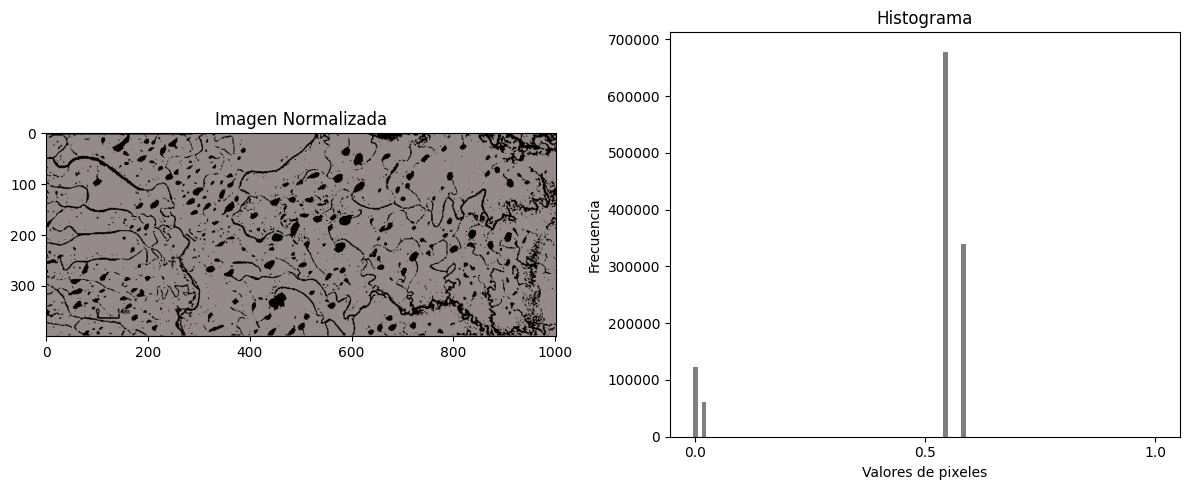

In [261]:
# HISTOGRAMA IMAGEN ORIGINAL
histogram1, bins1 = np.histogram(imagenProcesada.flatten(), bins=1000, range=(0, 1))
mostrar_imagen_y_histograma(imagenProcesada, histogram1, bins1)

# Convertir la imagen procesada a un formato adecuado para MeanShift
original=ope.RGB_to_bytes(imagenProcesada)
imagen_vectorizada = original.reshape(-1, 3)

# Aplicar el algoritmo MeanShift
bandwidth = estimate_bandwidth(imagen_vectorizada, quantile=0.6, n_samples=10000)
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(imagen_vectorizada)

# Obtener las etiquetas de los clusters
etiquetas_meanshift = meanshift.labels_

# Obtener los centroides de los clusters
centros_meanshift = meanshift.cluster_centers_

# Reconstruir la imagen original con los colores de los centroides
imagen_reconstruida = centros_meanshift[etiquetas_meanshift].reshape(original.shape).astype(np.uint8)

#normalizamos las imágenes para comparar los histogramas
imegenMeanShift=ope.normalize_rgb(imagen_reconstruida)

# HISTOGRAMA IMAGEN DESPUES DE MEAN SHIFT
histogram1, bins1 = np.histogram(imegenMeanShift.flatten(), bins=1000, range=(0, 1))
mostrar_imagen_y_histograma(imegenMeanShift, histogram1, bins1)

## BINARIZAMOS LOS RESULTADOS DE MEAN SHIFT

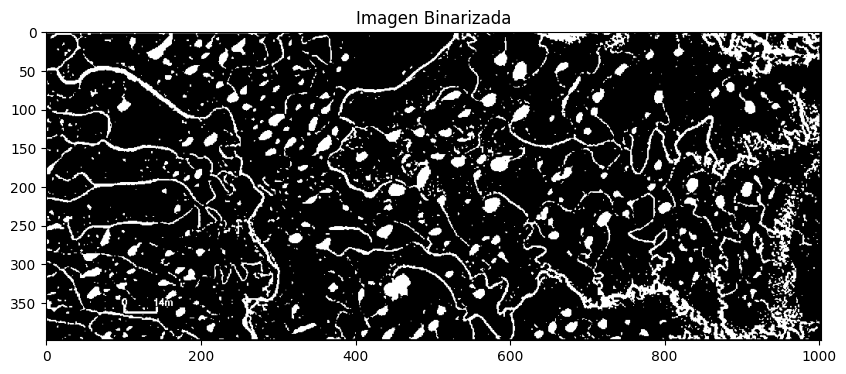

In [263]:
# Convertir las etiquetas a una imagen binarizada
imagen_segmentada = np.reshape(etiquetas_meanshift, original.shape[:2])
imagen_binarizada = np.zeros_like(imagen_segmentada)
imagen_binarizada[imagen_segmentada != 0] = 255
# Mostrar la imagen binarizada
plt.figure(figsize=(10, 10))
plt.imshow(imagen_binarizada, cmap='gray')  # Usar cmap='gray' para mostrar en escala de grises
plt.title('Imagen Binarizada')
plt.show()

## APLICAMOS LA MEDIANA PARA ELIMINAR RUIDO

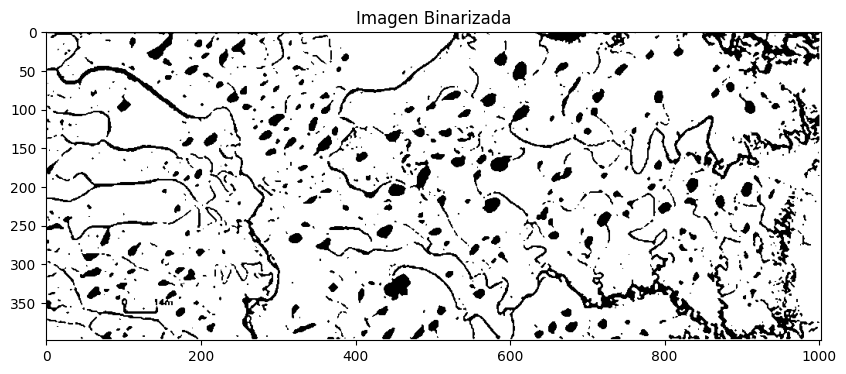

In [264]:
imagen_filtrada = np.zeros(imagen_binarizada.shape)

imagen_filtrada = ope.im_mediana(imagen_binarizada, np.ones((3, 3), bool))

# Invertir los píxeles negros y blancos
imagen_filtrada = 255 - imagen_filtrada

# Mostrar la imagen 
plt.figure(figsize=(10, 10))
plt.imshow(imagen_filtrada, cmap='gray')
plt.title('Imagen Binarizada')
plt.show()

## OBTENEMOS LOS CONTORNOS

In [265]:
print(imagen_filtrada.shape)
imagesave = ope.RGB_to_bytes(imagen_filtrada.astype(np.uint8))
print(imagesave.astype)

(399, 1003)
<built-in method astype of numpy.ndarray object at 0x0000016303154810>


In [266]:
# Extrae los contornos de los objetos
import cv2


contornos, _ = cv2.findContours(imagesave.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
'''
findContours devuelve una tupla donde el primer elemento es la lista de contornos y el segundo elemento es la jerarquía de contornos.
En este caso, solo nos interesa la lista de contornos, por eso usamos _ para ignorar el segundo elemento de la tupla.
'''

# Imprimir la cantidad de contornos
print("Cantidad de contornos:", len(contornos))

Cantidad de contornos: 1005


## GRAFICAMOS LOS CONTORNOS Y ETIQUEAMOS 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Area:  781.5
Perimetro:  126.95331692695618


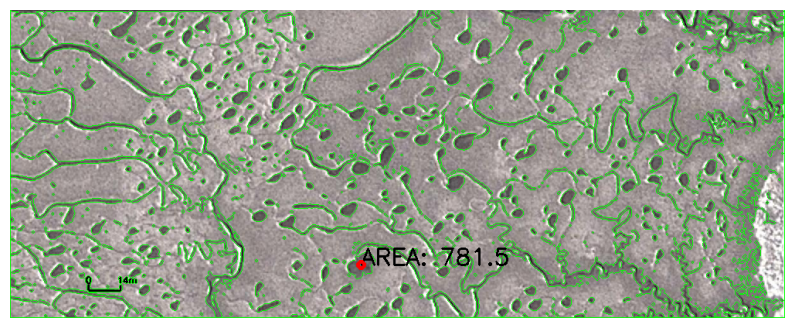

In [267]:
# Dibuja los contornos rectangulares en una imagen de salida
img_output = np.ones_like(imagenProcesada)

cv2.drawContours(imagenNormalizada, contornos, -1, (0, 255, 0), 1)

area = cv2.contourArea(contornos[186])
# Extraemos el perimetro de todos los contornos que hayan
perimetro = cv2.arcLength(contornos[186], True)

print("Area: ", area)
print("Perimetro: ", perimetro)

# Toma las medidas de los objetos
x, y, ancho, alto = cv2.boundingRect(contornos[186])

# Calcula el centro del contorno
centro_x = x + ancho // 2
centro_y = y + alto // 2

# Convierte el área a una cadena (string)
area_str = str(area)

# Muestra el área en el centro del contorno
cv2.putText(imagenNormalizada, 'AREA: ' + area_str, (centro_x, centro_y),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.circle(imagenNormalizada, (centro_x, centro_y), 4, (255, 0, 0), 3)


plt.figure(figsize=(10, 10))
plt.imshow(imagenNormalizada)
plt.axis('off')
plt.show()